Пытаюсь подать данные на DNNClassifier (https://www.youtube.com/watch?v=s0JvhHr3r8k) и обучить сеть, 
но переживаю целый ряд проблем


### ТЕКУЩИЕ ПРОБЛЕМЫ: 

1. Низкий Precision при стопроцентном Реколле. Возможно, это свидетельствует о переобученности системы. Возможно, нужно добавить новые фичи из датасета
2. В ту же корзину -- проверить, что в обучении используются все нужные фичи из датасета
3. Возможно, высокий реколл при низком пресижине говорит о высокой дисперсии данных. В свою очередь это может означать высокое значение случайной компоненты (ебаный рандом).


Текущие результаты:
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.4588015, accuracy_baseline = 0.5411985, auc = 0.5, auc_precision_recall = 0.72940075, average_loss = 0.7048409, global_step = 5000, label/mean = 0.4588015, loss = 7.0133862, precision = 0.4588015, prediction/mean = 0.5455505, recall = 1.0



### РАНЕЕ ЗАКРЫТЫЕ ПРОБЛЕМЫ И ВОПРОСЫ: 
1. Новый датасет оказался полным дном, в нём нет целой кучи данных.
2. Мало данных. РнД пацанов не хватает. Обучаюсь на всех сразу.
3. Набившая оскомину Unable to get element as bytes (https://stackoverflow.com/questions/47918681/internalerror-in-tensorflow-when-trying-to-save-a-checkpoint)

Чтобы её пофиксить: 
- удаляю пробелы
- удаляю символы &, +, ?, русские символы, короче все которые не latin-1
- возможно ещё в запятых проблема.

Ошибки в данных:
- также есть значения '#????!' и 'n/a'
- широко распространенная ошибка -- в ячейке хранится стринг, который пытаемся запроцессить как флоат (Gender)
- в процессе изменения значений в числовые столбцы закрались 'n/a'
- ЗАМЕНИТЬ ЗНАЧЕНИЕ "NA" (Северная Америка)

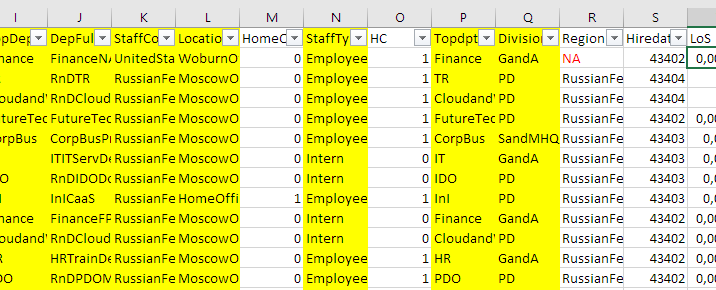

И всё равно не помогает. 
Надо либо сравнивать со сработавшими датасетами и искать в чем ошибка, либо отрезать фичи пока не заработает и выяснять в чем дело. Также есть вариант порезать датасет построчно.


Проблема нулевого присижена
https://stackoverflow.com/questions/48061976/precision-is-always-zero-tensorflow-metrics



##### TO DO:

1. Проверить фичи - check
2. Локализовать проблему с датасетом - check
3. Устранить её - check
4. Пробовать DNN в разных конфигурациях, следить за результатом - check
5. Попытаться прикрутить обучение на данных из 2019 - пока не реализовано
6. Зафиксить проблему с низким пресиженом при высоком реколле




In [1]:
import tensorflow as tf

from tensorflow.keras import layers


from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from tensorflow.feature_column import bucketized_column

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

tf.enable_eager_execution() #new
print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [153]:
#Preprocessing the data

# AllFiredAreFiredRnD2.6.csv
# 02-02-19-mainstructure2.csv
data = pd.read_csv('02-02-19-mainstructure3halftest.csv', sep=';', encoding='latin-1', low_memory=False)
#datatopivot = data[['EmplId', 'Y', 'M', 'TerminationFact']]
#pivoted = datatopivot.pivot_table(index = ['EmplId', 'Y'], 
#                        columns='M', values='TerminationFact', fill_value=0.0)
#merged = pd.merge(data, pivoted, how='left', on='EmplId')
#result = merged.drop_duplicates(subset='EmplId', keep='first', inplace=False)

#csvname = '14tmp3.csv'
#result.to_csv(path_or_buf= csvname)
#data = result

#csv at the end

data.head()

,Y,M,EmplId,FullnameEng,Status,VacationDaysCollected,TerminationFact,Terminationdate,TopDept,DepFull,...,Averageageintheteam,Averageageintheteam(Days),Agediffwithteam,Agediffwithteam1000,numberofteammates,Managersage,AgediffwithManager,Differentlocationwithmanager,Overtimehourscumul,Overtimehourspermonth
0,2018,10,10606,BerrioAlejandro,Active,0,0,0,9,1,...,47,17010,1,521,5,46,1,0,0,0
1,2018,10,10604,Balandyuk-OpalinskayaYaninaEdvardovna,Active,0,0,0,5,2,...,28,10071,1,998,1,34,1,0,0,0
2,2018,10,10603,ShiyanovVladimirGennadyevich,Active,0,0,0,10,3,...,31,11352,1,1183,17,39,1,0,0,0
3,2018,10,10601,NechiporukArtemMikhaylovich,Active,0,0,0,11,4,...,38,13723,1,829,5,47,1,0,0,0
4,2018,10,10600,ShaykhelislamovDamirIldarovich,Active,0,0,0,12,5,...,34,12545,1,878,3,41,1,0,0,0


In [154]:
data.columns

Index(['Y', 'M', 'EmplId', 'FullnameEng', 'Status', 'VacationDaysCollected',
       'TerminationFact', 'Terminationdate', 'TopDept', 'DepFull',
       'StaffCountry', 'Location', 'HomeOffice', 'StaffTypeName', 'HC',
       'Topdptreorg', 'Division', 'Region', 'Hiredate', 'LoS', 'DaysOfServ',
       'DoB', 'Age', 'Age(years)', 'Age(Days)', 'Gender', 'Grade', 'Manager',
       'SPAN', 'Performance', 'Talent', 'CR', 'CR1000', 'CRgroup',
       'Averageageintheteam', 'Averageageintheteam(Days)', 'Agediffwithteam',
       'Agediffwithteam1000', 'numberofteammates', 'Managersage',
       'AgediffwithManager', 'Differentlocationwithmanager',
       'Overtimehourscumul', 'Overtimehourspermonth'],
      dtype='object')

In [160]:
# Not appropriate for RandForest
#feat_EmplId = tf.feature_column.numeric_column('EmplId')
#feat_FullNameEng = tf.feature_column.categorical_column_with_hash_bucket('FullNameEng',hash_bucket_size=2300)

feat_HomeOffice = tf.feature_column.numeric_column('HomeOffice')
# feat_Averageage = tf.feature_column.numeric_column('Averageageintheteam')
# feat_Agediffwithteam = tf.feature_column.numeric_column('Agediffwithteam1000')
# feat_Grade = tf.feature_column.numeric_column('Grade')
# feat_Manager = tf.feature_column.numeric_column('Manager')
# feat_SPAN = tf.feature_column.numeric_column('SPAN')
# feat_Performance = tf.feature_column.numeric_column('Performance')
# feat_Talent = tf.feature_column.numeric_column('Talent')
# feat_CR = tf.feature_column.numeric_column('CR')
# feat_numberofteammates = tf.feature_column.numeric_column('numberofteammates')
# feat_Managerage = tf.feature_column.numeric_column('Managersage')
# feat_Differentlocationwithmanager = tf.feature_column.numeric_column('Differentlocationwithmanager')
# feat_Overtimehourscumul = tf.feature_column.numeric_column('Overtimehourscumul')
# feat_Overtimehourspermonth = tf.feature_column.numeric_column('Overtimehourspermonth')
# feat_Location = tf.feature_column.numeric_column('Location')
# feat_LoS = tf.feature_column.numeric_column('LoS')
# feat_DoB = tf.feature_column.numeric_column('DoB')
# feat_Age = tf.feature_column.numeric_column('Age')
# feat_HC = tf.feature_column.numeric_column('HC')
# feat_AgediffwithManager = tf.feature_column.numeric_column('AgediffwithManager')
# feat_Region = tf.feature_column.numeric_column('Region')
# feat_Hiredate = tf.feature_column.numeric_column('Hiredate')
# feat_StaffTypeName = tf.feature_column.numeric_column('StaffTypeName')
# feat_Gender = tf.feature_column.numeric_column('Gender')

# feat_VacationDaysCollected = tf.feature_column.numeric_column('VacationDaysCollected')
# feat_DepFull = tf.feature_column.numeric_column('DepFull')
# feat_StaffCountry = tf.feature_column.numeric_column('StaffCountry')
# feat_TopDept = tf.feature_column.numeric_column('TopDept')
# feat_Topdptreorg = tf.feature_column.numeric_column('Topdptreorg')
# feat_Division = tf.feature_column.numeric_column('Division')
# feat_DaysOfServ = tf.feature_column.numeric_column('DaysOfServ')
# feat_CRoneT = tf.feature_column.numeric_column('CRoneT')
# feat_CRgroup = tf.feature_column.numeric_column('CRgroup')

feat_Terminationdate = tf.feature_column.numeric_column('Terminationdate')





bucketized_HomeOffice = bucketized_column(feat_HomeOffice, boundaries=[0,2])
# bucketized_Averageage = bucketized_column(feat_Averageage, boundaries=[0,100])
# bucketized_Agediffwithteam = bucketized_column(feat_Agediffwithteam, boundaries=[0,1000])
# bucketized_Grade = bucketized_column(feat_Grade, boundaries=[0,100])
# bucketized_Manager = bucketized_column(feat_Manager, boundaries=[0,100])
# bucketized_SPAN = bucketized_column(feat_SPAN, boundaries=[0,100])
# bucketized_Performance = bucketized_column(feat_Performance, boundaries=[0,100])
# bucketized_Talent = bucketized_column(feat_Talent, boundaries=[0,2])
# bucketized_CR = bucketized_column(feat_CR, boundaries=[0,100])
# bucketized_numberofteammates = bucketized_column(feat_numberofteammates, boundaries=[0,100])
# bucketized_Managerage = bucketized_column(feat_Managerage, boundaries=[0,100])
# bucketized_Differentlocationwithmanager = bucketized_column(feat_Differentlocationwithmanager, boundaries=[0,100])
# bucketized_Overtimehourscumul = bucketized_column(feat_Overtimehourscumul, boundaries=[0,100])
# bucketized_Overtimehourspermonth = bucketized_column(feat_Overtimehourspermonth, boundaries=[0,100])
# bucketized_Location = bucketized_column(feat_Location, boundaries=[0,61])
# bucketized_AgediffwithManager = bucketized_column(feat_AgediffwithManager, boundaries=[0,100])
# bucketized_HC = bucketized_column(feat_HC, boundaries=[0,2])
# bucketized_Age = bucketized_column(feat_Age, boundaries=[0,100])
# bucketized_DoB = bucketized_column(feat_DoB, boundaries=[20500,37000])
# bucketized_LoS = bucketized_column(feat_LoS, boundaries=[0,22])
# bucketized_Region = bucketized_column(feat_Region, boundaries=[0,7])
# bucketized_Hiredate = bucketized_column(feat_Hiredate, boundaries=[35000,44000])
# bucketized_StaffTypeName = bucketized_column(feat_StaffTypeName, boundaries=[0,2])
# bucketized_Gender = bucketized_column(feat_Gender, boundaries=[0,2])


# bucketized_DepFull = bucketized_column(feat_DepFull, boundaries=[0,1500])
# bucketized_StaffCountry = bucketized_column(feat_StaffCountry, boundaries=[0,70])
# bucketized_TopDept = bucketized_column(feat_TopDept, boundaries=[0,60])
# bucketized_Topdptreorg = bucketized_column(feat_Topdptreorg, boundaries=[0,40])
# bucketized_Division = bucketized_column(feat_Division, boundaries=[0,6])
# bucketized_DaysOfServ = bucketized_column(feat_DaysOfServ, boundaries=[0,8000])
# bucketized_CRoneT = bucketized_column(feat_CRoneT, boundaries=[0,8900])
# bucketized_CRgroup = bucketized_column(feat_CRgroup, boundaries=[0,6])

bucketized_Terminationdate = bucketized_column(feat_Terminationdate, boundaries=[0,200])


# 
# feat_cols = [feat_Y,feat_M,
#              feat_VacationDaysCollected,feat_TopDept,
#              feat_StaffCountry,feat_Location,feat_HomeOffice,
#              feat_StaffTypeName,feat_TopDptReorg,
#              feat_Region,feat_Hiredate,bucketized_LoS,bucketized_DoB,bucketized_Age,
#              bucketized_AgediffwithManager,bucketized_HC]


# 
# feat_DepFull = tf.feature_column.categorical_column_with_hash_bucket('DepFull',hash_bucket_size=470)
# feat_VacationDaysCollected = tf.feature_column.numeric_column('VacationDaysCollected')
# feat_TopDept = tf.feature_column.categorical_column_with_hash_bucket('TopDept',hash_bucket_size=30)
# feat_StaffCountry = tf.feature_column.categorical_column_with_hash_bucket('StaffCountry',hash_bucket_size=50)
# # feat_TopDptReorg = tf.feature_column.categorical_column_with_hash_bucket('Topdptreorg',hash_bucket_size=35)
# 

# feat_cols = [bucketized_Age,
#              bucketized_HomeOffice,bucketized_Location,
#              bucketized_HC,bucketized_Region,bucketized_Hiredate,
#              bucketized_LoS,bucketized_DoB,bucketized_Gender,
#              bucketized_Grade]

# feat_cols = [bucketized_Age,bucketized_Grade,
#              bucketized_LoS,bucketized_DoB,bucketized_Gender,
#              bucketized_Manager,bucketized_Talent,bucketized_CR,
#              bucketized_numberofteammates,bucketized_Managerage,
#              bucketized_Differentlocationwithmanager,bucketized_StaffTypeName,
#              bucketized_Agediffwithteam,bucketized_AgediffwithManager,
#              bucketized_Averageage]


feat_cols = [bucketized_HomeOffice,bucketized_Terminationdate]


# feat_cols = [bucketized_HomeOffice,bucketized_Age,bucketized_Location,
#              bucketized_HC,bucketized_Region,bucketized_Hiredate,
#              bucketized_LoS,bucketized_DoB,bucketized_Gender,
#              bucketized_Grade,bucketized_Manager,bucketized_SPAN,
#              bucketized_Performance,bucketized_Talent,bucketized_CR,
#              bucketized_numberofteammates,bucketized_Managerage,
#              bucketized_Differentlocationwithmanager,bucketized_StaffTypeName,
#              bucketized_Agediffwithteam,bucketized_AgediffwithManager,
#              bucketized_Averageage,bucketized_TopDept,bucketized_DepFull,bucketized_StaffCountry,
#              bucketized_Topdptreorg,
#              bucketized_Division,bucketized_DaysOfServ,
#              bucketized_CRoneT,bucketized_CRgroup,bucketized_Terminationdate]

In [161]:
labels = data['TerminationFact']
x_data = data.drop('TerminationFact',axis=1)
#x_data = data


x_data.head()


,Y,M,EmplId,FullnameEng,Status,VacationDaysCollected,Terminationdate,TopDept,DepFull,StaffCountry,...,Averageageintheteam,Averageageintheteam(Days),Agediffwithteam,Agediffwithteam1000,numberofteammates,Managersage,AgediffwithManager,Differentlocationwithmanager,Overtimehourscumul,Overtimehourspermonth
0,2018,10,10606,BerrioAlejandro,Active,0,0,9,1,1,...,47,17010,1,521,5,46,1,0,0,0
1,2018,10,10604,Balandyuk-OpalinskayaYaninaEdvardovna,Active,0,0,5,2,2,...,28,10071,1,998,1,34,1,0,0,0
2,2018,10,10603,ShiyanovVladimirGennadyevich,Active,0,0,10,3,2,...,31,11352,1,1183,17,39,1,0,0,0
3,2018,10,10601,NechiporukArtemMikhaylovich,Active,0,0,11,4,2,...,38,13723,1,829,5,47,1,0,0,0
4,2018,10,10600,ShaykhelislamovDamirIldarovich,Active,0,0,12,5,2,...,34,12545,1,878,3,41,1,0,0,0


In [166]:
X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.4,random_state=101)
##X_train2, X_test2, y_train2, y_test2 = train_test_split(x_data,labels, test_size=0.99, random_state=101)

# Повторяющиеся нормальные значения prec и recall случаются на False + True и False + False связке
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=10,num_epochs=1,shuffle=False)

#BoostedTreesClassifier
#BoostedTreesRegressor

# model = tf.estimator.BoostedTreesClassifier(feature_columns=feat_cols, 
#     n_batches_per_layer=100, 
#     n_trees=15000, 
#     label_dimension = labels,
#     max_depth=5,
#     learning_rate=0.1)

# boosted_trees_regressor(feature_columns, n_batches_per_layer,
#   model_dir = NULL, label_dimension = 1L, weight_column = NULL,
#   n_trees = 100L, max_depth = 6L, learning_rate = 0.1,
#   l1_regularization = 0, l2_regularization = 0, tree_complexity = 0,
#   min_node_weight = 0, config = NULL)

model_dir ="tmp\modeldirs22"
model = tf.estimator.DNNClassifier(
    feature_columns=feat_cols,
    model_dir=model_dir, 
    hidden_units=[25, 32, 16, 8, 4, 2],
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.2),
    n_classes=2)

# hidden_units=[25, 32, 16, 8, 4, 2]
# 

# ### WORKING 
# model_dir ="tmp\modeldirs2"
# model = tf.estimator.DNNClassifier(
#     feature_columns=feat_cols,
#     model_dir=model_dir, 
#     hidden_units=[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2],optimizer=tf.train.ProximalAdagradOptimizer(
#       learning_rate=0.1,
#       l1_regularization_strength=0.001
#     ))



#model = tf.estimator.BoostedTreesClassifier(feature_columns=feat_cols, n_batches_per_layer=100,
#  n_trees = 15000, max_depth = 10, n_classes=2,
#  learning_rate = 0.1, l1_regularization = 0, l2_regularization = 0,
#  tree_complexity = 0, min_node_weight = 0)

#Instead Of:
#model = tf.estimator.LinearRegressor(feature_columns=feat_cols)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp\\modeldirs22', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002D4D9B110F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [167]:
model.train(input_fn=input_func,steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp\modeldirs22\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2000 into tmp\modeldirs22\model.ckpt.
INFO:tensorflow:loss = 6.146208, step = 2001
INFO:tensorflow:global_step/sec: 375.534
INFO:tensorflow:loss = 6.7330866, step = 2101 (0.267 sec)
INFO:tensorflow:global_step/sec: 354.301
INFO:tensorflow:loss = 7.057593, step = 2201 (0.282 sec)
INFO:tensorflow:global_step/sec: 197.767
INFO:tensorflow:loss = 6.9426236, step = 2301 (0.507 sec)
INFO:tensorflow:global_step/sec: 319.324
INFO:tensorflow:loss = 6.124262, step = 2401 (0.312 sec)
INFO:tensorflow:global_step/sec: 314.317
INFO:tensorflow:loss = 6.765666, step = 2501 (0.319 sec)
INFO:tensorflow:global_step/sec: 330.917
INFO:tensorflow:loss = 6.7320123, 

In [159]:
results = model.evaluate(eval_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-06-21:04:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp\modeldirs21\model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-06-21:04:41
INFO:tensorflow:Saving dict for global step 4000: accuracy = 0.5411985, accuracy_baseline = 0.5411985, auc = 0.5, auc_precision_recall = 0.72940075, average_loss = 0.69008696, global_step = 4000, label/mean = 0.4588015, loss = 6.8665795, precision = 0.0, prediction/mean = 0.4717757, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: tmp\modeldirs21\model.ckpt-4000


In [118]:
results

{'accuracy': 0.693778,
 'accuracy_baseline': 0.6937779,
 'auc': 0.5,
 'auc_precision_recall': 0.65311104,
 'average_loss': 0.62259406,
 'label/mean': 0.30622205,
 'loss': 6.22341,
 'precision': 0.0,
 'prediction/mean': 0.2553137,
 'recall': 0.0,
 'global_step': 4000}

In [119]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=10,num_epochs=1,shuffle=False)

In [120]:
predictions = model.predict(pred_input_func)

In [121]:
my_pred = list(predictions)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp\modeldirs18\model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [122]:
my_pred

[{'logits': array([-1.0704714], dtype=float32),
  'logistic': array([0.25531343], dtype=float32),
  'probabilities': array([0.74468654, 0.25531346], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object)},
 {'logits': array([-1.0704714], dtype=float32),
  'logistic': array([0.25531343], dtype=float32),
  'probabilities': array([0.74468654, 0.25531346], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object)},
 {'logits': array([-1.0704714], dtype=float32),
  'logistic': array([0.25531343], dtype=float32),
  'probabilities': array([0.74468654, 0.25531346], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object)},
 {'logits': array([-1.0704714], dtype=float32),
  'logistic': array([0.25531343], dtype=float32),
  'probabilities': array([0.74468654, 0.25531346], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object)},
 {'logit

In [123]:
dfxtest = pd.DataFrame(X_test)
dfxtest.to_csv("02-02-19-DNNres20.csv")

X_test

,Y,M,EmplId,FullnameEng,Status,VacationDaysCollected,Terminationdate,TopDept,DepFull,StaffCountry,...,Averageageintheteam,Averageageintheteam(Days),Agediffwithteam,Agediffwithteam1000,numberofteammates,Managersage,AgediffwithManager,Differentlocationwithmanager,Overtimehourscumul,Overtimehourspermonth
3834,2018,2,5394,LoisonannaDmitrievna,Active,0,0,42,150,9,...,30,10778,1,979,4,36,1,1,0,0
1379,2018,10,2230,DelgadoJoseManuel,Active,0,0,25,260,21,...,41,15026,1,1081,4,44,1,0,0,0
23,2018,3,157,NikishinandreyVictorovich,Active,0,0,11,1155,9,...,44,15900,1,1079,8,60,1,1,0,0
8501,2018,9,8892,BotarevStepanIgorevich,Active,-1,0,21,230,2,...,27,9735,1,895,6,31,1,0,24,"2,4"
9886,2018,10,9486,ZamaletdinovDenisFaritovich,Active,18,0,14,233,2,...,27,9835,1,1125,2,33,1,0,0,0
6832,2018,10,7944,KotenevaAlyonaValerievna,Active,17,0,7,190,2,...,27,9778,1,834,7,29,1,0,8,"0,8"
6746,2018,10,7894,PopovMaximBorisovich,Active,12,0,11,59,2,...,34,12408,1,1109,32,44,1,0,0,0
8791,2018,10,9009,AkopyanGeorgySamvelovich,Active,26,0,10,513,2,...,38,13692,1,935,12,33,1,1,0,0
4897,2018,7,6573,KryuchkovaYuliyaVadimovna,Active,-4,0,13,463,2,...,37,13428,1,968,6,39,1,0,0,0
9636,2018,9,9387,BerezinskayaYuliyaMikhaylovna,Active,6,0,24,146,2,...,34,12324,1,656,6,27,1,0,0,0


In [124]:
for _ in my_pred:
    print(_)
    
dfpred = pd.DataFrame(my_pred)
dfpred.to_csv("02-02-19-DNNres20res.csv")

{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), '

{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), '

{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), '

{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), '

{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), 'logistic': array([0.25531343], dtype=float32), 'probabilities': array([0.74468654, 0.25531346], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object)}
{'logits': array([-1.0704714], dtype=float32), '